In [1]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

from lib import Augmentation_methods
from lib import data_preparation
from lib import vae_augmentation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D ,Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import confusion_matrix
import seaborn as sns

2023-01-09 21:15:36.848970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BASEDIR = Path("/store/projects/fallki/")
FAKEDIR = BASEDIR / "Fake-Events" / "2. Fake-Events Messung"
df_fake = pd.read_parquet(BASEDIR / FAKEDIR / 'gSensoren_FakeEvents.parquet')

# Data preparation
In this notebook we try to train a deep neural network to seperate Dummy falls from the other fall events by training it on the stft picture we generate for all of them.

In [3]:
dummy_lab_data = data_preparation.fake_lab_data()

In [4]:
dummy_lab_data = dummy_lab_data[0]
dummy_lab_data =pd.DataFrame(dummy_lab_data,columns=['z'])
dummy_lab_data

,z
0,"[1028.0, 1030.0, 1028.0, 1030.0, 1030.0, 1028...."
1,"[1038.0, 1040.0, 1040.0, 1040.0, 1042.0, 1038...."
2,"[1038.0, 1040.0, 1042.0, 1036.0, 1036.0, 1036...."
3,"[1039.0, 1039.0, 1037.0, 1039.0, 1040.0, 1039...."
4,"[1030.0, 1030.0, 1032.0, 1032.0, 1030.0, 1028...."
...,...
67,"[1026.0, 1026.0, 1024.0, 1026.0, 1026.0, 1026...."
68,"[1039.0, 1037.0, 1035.0, 1039.0, 1037.0, 1041...."
69,"[1036.0, 1038.0, 1040.0, 1036.0, 1036.0, 1036...."
70,"[1028.0, 1026.0, 1029.0, 1026.0, 1026.0, 1032...."


### Data preparation

In [5]:
def SignalToSpectrum(signal, samplerate=1600):
    SIGNAL_LENGTH = samplerate * 10
    F = stft(signal[:SIGNAL_LENGTH], 1600, nperseg=128)[2]
    F = F[2:,]
    return np.expand_dims(np.abs(F), axis=2) # Add extra dimension for TF Conv2D

In [6]:
M = []
for i in range(len(dummy_lab_data)):
    M.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": len(dummy_lab_data.z[i]),
              "spectrum": SignalToSpectrum(dummy_lab_data.z[i])})
dummy_df = pd.DataFrame.from_dict(M)

In [7]:
# normalize the spectrum to facilitate training
dummy_df["normalizedSpectrum"] = dummy_df["spectrum"] / dummy_df["spectrum"].map(np.max).max()

In [8]:
normalization_factor = dummy_df["spectrum"].map(np.max).max()

In [9]:
dummy_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Dummy,1,16060,"[[[218.2394841808716], [0.3883757340634493], [...","[[[0.4298988452236898], [0.0007650415790407816..."
1,Dummy,1,16023,"[[[220.27029916916067], [0.15571238230920692],...","[[[0.43389924424225085], [0.000306729891673859..."
2,Dummy,1,16103,"[[[220.1979075536411], [0.10061251128959935], ...","[[[0.4337566436856534], [0.0001981914619199109..."
3,Dummy,1,16027,"[[[220.5208287915735], [0.15426393464651908], ...","[[[0.43439274978628134], [0.000303876668390760..."
4,Dummy,1,16066,"[[[218.47629161994428], [0.06429553709989536],...","[[[0.43036532013761214], [0.000126652504041725..."
...,...,...,...,...,...
67,Dummy,1,16008,"[[[217.5026606968022], [0.38136716128226256], ...","[[[0.42844741416792076], [0.000751235748456975..."
68,Dummy,1,15967,"[[[220.18991047477957], [0.12906525952576858],...","[[[0.43374089064728527], [0.000254239081607428..."
69,Dummy,1,16040,"[[[220.39650639869222], [0.33732010067619034],...","[[[0.4341478534361286], [0.0006644696870308276..."
70,Dummy,1,16005,"[[[218.20000668823081], [0.25724782513819655],...","[[[0.4298210805214761], [0.0005067393894294655..."


In [10]:
X_train = np.stack(dummy_df["normalizedSpectrum"])
y_train = dummy_df["istSturz"]

### VAE Augmentation

In [11]:
def sample_z(args):
        z_mean, z_log_var = args
        eps = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
        return z_mean + K.exp(z_log_var / 2) * eps

In [12]:
latent_dim = 2 # Number of latent dim parameters

# Encoder 
input_data = Input(shape=(63,251,1), name='encoder_input')
x = layers.Conv2D(32,3, padding='same', activation='relu')(input_data)
x = layers.Conv2D(64,3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_log_var = layers.Dense(latent_dim, name='latent_sigma')(x) 
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
encoder = Model(input_data, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2],conv_shape[3]))(x)
x = Conv2DTranspose(64,3, padding='same', activation='relu')(x)
x = Conv2DTranspose(32,3, padding='same', activation='sigmoid')(x)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='decoder_output')(x)
decoder = Model(decoder_input, decoder_output, name='decoder')

2023-01-09 21:16:37.472367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Training VAE model with train data 
vae = vae_augmentation.VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam())
vae.fit(X_train, epochs = 30,batch_size=9)

Epoch 1/30
8/8 [==============================] - 4s 410ms/step - loss: 5099.4571 - reconstruction_loss: 4194.9702 - kl_loss: 0.9413
Epoch 2/30
8/8 [==============================] - 3s 411ms/step - loss: 1372.3882 - reconstruction_loss: 582.1639 - kl_loss: 422.0546
Epoch 3/30
8/8 [==============================] - 3s 409ms/step - loss: 273.6685 - reconstruction_loss: 246.5507 - kl_loss: 1.9616
Epoch 4/30
8/8 [==============================] - 3s 410ms/step - loss: 184.2165 - reconstruction_loss: 191.9553 - kl_loss: 0.3444
Epoch 5/30
8/8 [==============================] - 3s 413ms/step - loss: 170.4491 - reconstruction_loss: 162.7154 - kl_loss: 0.8579
Epoch 6/30
8/8 [==============================] - 3s 422ms/step - loss: 168.1101 - reconstruction_loss: 161.2025 - kl_loss: 1.6377
Epoch 7/30
8/8 [==============================] - 3s 416ms/step - loss: 172.1259 - reconstruction_loss: 159.1861 - kl_loss: 1.1473
Epoch 8/30
8/8 [==============================] - 3s 414ms/step - loss: 153.23

3/3 [==============================] - 0s 60ms/step


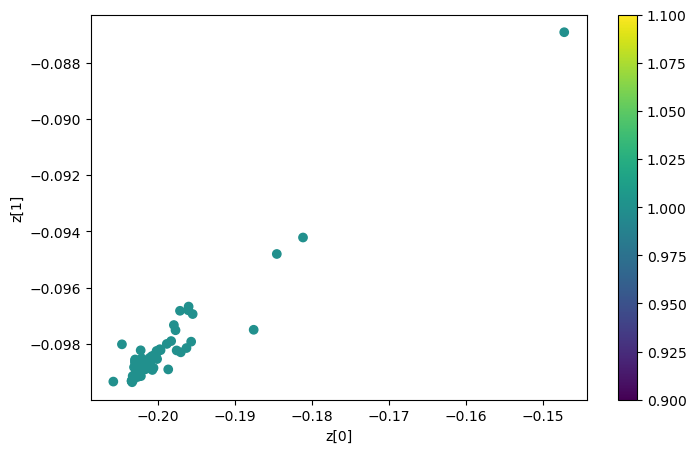

In [14]:
# predicting the distribution
z_mean, z_log_var, z = vae.encoder.predict(X_train)
plt.figure(figsize=(8, 5))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=dummy_df["istSturz"])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [ ]:
# predicting usinbg decoder - Augmentation
augmented_data= vae_augmentation.plot_latent_space(vae, z_mean, decoder, n = 30)

In [16]:
augmented_data = np.expand_dims(np.array(augmented_data), axis=3)

### Data preparation of augmented events 

In [17]:
M = []
for i in range(len(augmented_data)):
    M.append({"event": "Dummy" ,
              "istSturz": 1,
              "signalLenght": 16000,
              "spectrum": normalization_factor * augmented_data[i],
              "normalizedSpectrum":augmented_data[i]})
vae_df = pd.DataFrame.from_dict(M)

In [18]:
vae_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Dummy,1,16000,"[[[54.800686], [9.27224], [4.8285885], [2.0308...","[[[0.10794908], [0.018264912], [0.009511591], ..."
1,Dummy,1,16000,"[[[54.800686], [9.273667], [4.829142], [2.0311...","[[[0.10794908], [0.018267725], [0.0095126815],..."
2,Dummy,1,16000,"[[[54.800686], [9.27509], [4.8296876], [2.0314...","[[[0.10794908], [0.018270528], [0.009513755], ..."
3,Dummy,1,16000,"[[[54.800686], [9.27652], [4.8302374], [2.0317...","[[[0.10794908], [0.018273344], [0.009514838], ..."
4,Dummy,1,16000,"[[[54.800686], [9.277944], [4.8307877], [2.032...","[[[0.10794908], [0.01827615], [0.0095159225], ..."
...,...,...,...,...,...
895,Dummy,1,16000,"[[[54.800686], [9.411265], [4.8836966], [2.062...","[[[0.10794908], [0.018538773], [0.009620145], ..."
896,Dummy,1,16000,"[[[54.800686], [9.412772], [4.8842893], [2.062...","[[[0.10794908], [0.01854174], [0.009621313], [..."
897,Dummy,1,16000,"[[[54.800686], [9.414273], [4.884883], [2.0631...","[[[0.10794908], [0.018544698], [0.009622482], ..."
898,Dummy,1,16000,"[[[54.800686], [9.415781], [4.8854756], [2.063...","[[[0.10794908], [0.018547667], [0.0096236495],..."


### Data preparation of postive events

In [19]:
L = []
for (teensy, event, run, rep), ss in df_fake.groupby(["teensy", "experiment", "run", "rep"]):
    L.append({"event": event,
              "run": run,
              "istSturz": int(event == "Dummy"),
              "signalLenght": len(ss["z"]),
              "spectrum": SignalToSpectrum(ss["z"])})
df = pd.DataFrame.from_dict(L)
df.drop('run', inplace=True, axis=1)

In [20]:
# normalize the spectrum to facilitate training
df["normalizedSpectrum"] = df["spectrum"] / df["spectrum"].map(np.max).max()

### Append positive and augmented dummy data

In [21]:
final_df = []
final_df = df.append(vae_df)

In [22]:
#shuffle the final dataframe
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,1.5L Flasche,0,16039,"[[[220.32607334982728], [0.13758971914965154],...","[[[0.3220722191017051], [0.0002011283798524764..."
1,Stuhl kippt,0,16094,"[[[220.29936655250802], [0.26373857256812516],...","[[[0.3220331791581027], [0.0003855325247632510..."
2,Dummy,1,16000,"[[[54.800686], [9.322716], [4.8482428], [2.042...","[[[0.10794908], [0.018364344], [0.009550307], ..."
3,Dummy,1,16000,"[[[54.800686], [9.325107], [4.849296], [2.0427...","[[[0.10794908], [0.018369053], [0.009552381], ..."
4,Pflegeartikel,0,15979,"[[[220.53424418225683], [0.3064355157633084], ...","[[[0.32237652281362383], [0.000447946832042707..."
...,...,...,...,...,...
1974,Hantel,0,16007,"[[[218.0301112404999], [0.12397317522895768], ...","[[[0.3187159862224925], [0.0001812237428281033..."
1975,Koffer,0,16065,"[[[220.4261011881106], [0.14968607131956452], ...","[[[0.32221843959825386], [0.000218810803576398..."
1976,Koffer,0,16070,"[[[220.27302302319782], [0.3589355964112507], ...","[[[0.32199467023895884], [0.000524691346299328..."
1977,Krücken,0,16016,"[[[218.41193034689974], [0.14933477012675103],...","[[[0.31927412863852134], [0.000218297272186208..."


In [23]:
X = np.stack(final_df["normalizedSpectrum"].to_list())
y = final_df["istSturz"].to_numpy()

### Classificator model

In [24]:
# initialize a sequential network model https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
mdl = Sequential()
mdl.add(Conv2D(8, (63, 5), activation="relu", input_shape=(63, 251, 1)))
mdl.add(MaxPooling2D((1, 4)))
mdl.add(Flatten())
mdl.add(Dense(1))
mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
mdl.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1, 247, 8)         2528      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 61, 8)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 488)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 489       
                                                                 
Total params: 3,017
Trainable params: 3,017
Non-trainable params: 0
_________________________________________________________________


In [25]:
# split data in train and test set
train, test = train_test_split(range(len(y)), test_size=0.2,stratify= y)

### To plot accuracy and loss curve after each epoch

In [26]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):   
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

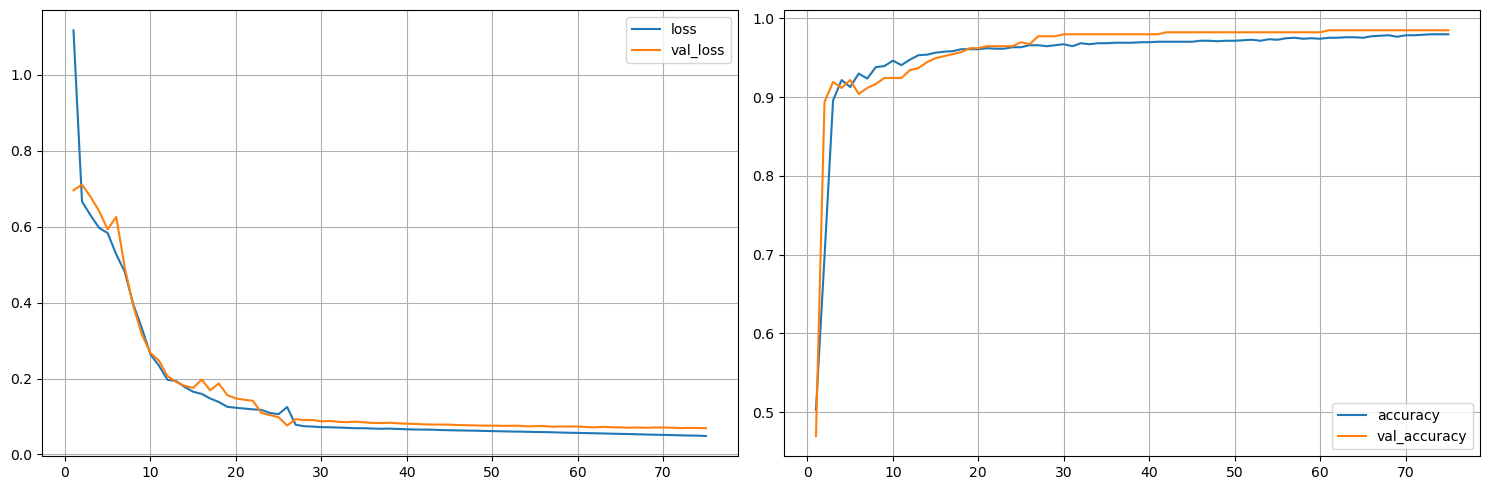

50/50 [==============================] - 1s 14ms/step - loss: 0.0485 - accuracy: 0.9798 - val_loss: 0.0690 - val_accuracy: 0.9848


In [27]:
# actual training..
callbacks_list = [PlotLearning()]
history = mdl.fit(X[train, ], y[train], epochs=75, validation_data=(X[test,], y[test]),callbacks=callbacks_list)

In [28]:
ypred = mdl.predict(X).ravel()
threshold = 0.10
pd.crosstab(final_df['event'], ypred >= threshold)

62/62 [==============================] - 0s 3ms/step


col_0,False,True
event,,
1.5L Flasche,55,17
2 Bücher,66,6
Dummy,3,969
Getränkeflasche,71,1
Handy,72,0
Hantel,71,0
Koffer,67,5
Krücken,72,0
Möbel verrücken,71,1


In [35]:
y_predictions = (mdl.predict(X) > 0.1).astype("int32")
y_predictions= y_predictions.ravel()

62/62 [==============================] - 0s 3ms/step


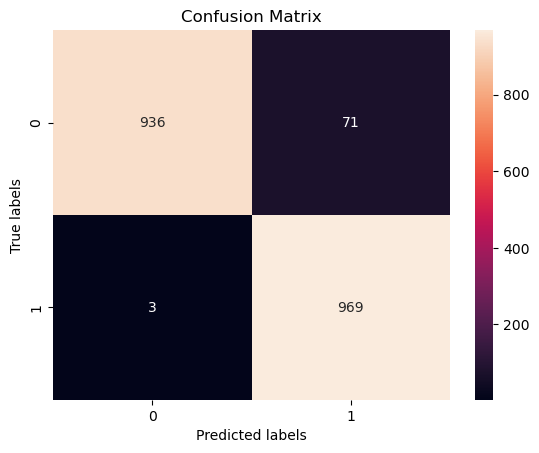

In [36]:
cm = confusion_matrix(y,y_predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()      
